# Imports

In [7]:
import numpy as np
from agent import RL_Agent_v1
from env_versions import env_v1, env_v2, env_v3, env_v4
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch
import time
import sys
from tqdm.notebook import tqdm


## Rendering

In [2]:
def render(episode, env):
    
    fig = plt.figure()
    img = plt.imshow(env.draw())
    plt.axis('off')

    def animate(i):
        img.set_data(episode[i])
        return img,

    anim = FuncAnimation(fig, animate, frames=len(episode), interval=100, blit=True)
    html = HTML(anim.to_jshtml())
    
    plt.close(fig)
    # os.remove(None0000000.png)
    
    return html

def render_to_video(episode, env, save_file = 'random.gif', fps = 10):
    
    fig = plt.figure()
    img = plt.imshow(env.draw())
    plt.axis('off')

    def animate(i):
        img.set_data(episode[i])
        return img,

    anim = FuncAnimation(fig, animate, frames=len(episode), interval=100, blit=True)
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=1800)

    anim.save(save_file, writer=writer)
    
    plt.close(fig)
    # os.remove(None0000000.png)

def run_fixed_episode(env, agent, max_steps = 99, init_state = 1):
    frames = []
    env.reset()
    done = False
    total_reward = 0
    state = np.concatenate( (env.air_hockey.ball_pos, env.air_hockey.ball_vel, env.air_hockey.self_hand_pos)  )
    for i in range(max_steps):
        observation = env.draw()
        frames.append( observation )
        action = agent.get_action( state )
        state, reward, done, __ = env.step(action)
        total_reward += reward
        if done:
            break
    return frames, total_reward

def run_fixed_episode_v5(env, agent, max_steps = 99, init_state = 1):
    frames = []; action_array = []
    env.reset()
    done = False
    total_reward = 0
    state = np.concatenate( (env.air_hockey.ball_pos, env.air_hockey.ball_vel, env.air_hockey.self_hand_pos)  )
    for i in range(max_steps):
        observation = env.draw()
        frames.append( observation )
        action = agent.get_action( state )
        action_array.append(action)
        state, reward, done, __ = env.step(action)
        total_reward += reward
        if done:
            break
    return frames, total_reward, action_array

%matplotlib inline
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams["animation.html"] = "jshtml"


In [3]:
#filler
def dist( pos1, pos2 ):
    return np.linalg.norm( pos1-pos2 )

def ball_out( ball_pose, env ):
    return (ball_pose[0] < env.air_hockey.ball_radious or ball_pose[0] > env.x_width-env.air_hockey.ball_radious or
            ball_pose[1] < env.air_hockey.ball_radious or ball_pose[1] > env.y_heigth-env.air_hockey.ball_radious)
def ball_ok(ball_pose, self_pose, enemy_pose, env):
    return (dist( ball_pose, self_pose ) > env.air_hockey.hand_radious + env.air_hockey.ball_radious and
            dist( ball_pose, enemy_pose ) > env.air_hockey.hand_radious + env.air_hockey.ball_radious)

def fill_buffer(agent, env, buffer_length):
    for i in tqdm(range(buffer_length)):
        ball_pose = np.array( [np.random.rand()*(env.x_width-2*env.air_hockey.ball_radious)+env.air_hockey.ball_radious
                , np.random.rand()*(env.y_heigth-2*env.air_hockey.ball_radious)+env.air_hockey.ball_radious] )
        self_pose = np.array( [np.random.rand()*(env.x_width-2*env.air_hockey.hand_radious)+env.air_hockey.hand_radious, 
            np.random.rand()*(env.y_heigth/2-2*env.air_hockey.hand_radious)+env.air_hockey.hand_radious] )
        enemy_pose = np.array( [np.random.rand()*(env.x_width-2*env.air_hockey.hand_radious)+env.air_hockey.hand_radious, 
            np.random.rand()*(env.y_heigth/2-2*env.air_hockey.hand_radious)+env.air_hockey.hand_radious+env.y_heigth/2] )
        
        while( not ball_ok(ball_pose, self_pose, enemy_pose, env) ):
            ball_pose = np.array( [np.random.rand()*(env.x_width-2*env.air_hockey.ball_radious)+env.air_hockey.ball_radious
                , np.random.rand()*(env.y_heigth-2*env.air_hockey.ball_radious)+env.air_hockey.ball_radious] )
        env.reset(ball_pos = ball_pose, self_pos = self_pose, enemy_pos = enemy_pose)
        state = np.concatenate( (env.air_hockey.ball_pos, env.air_hockey.ball_vel, env.air_hockey.self_hand_pos)  )
        action = agent.get_action(state, 1)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push( state, action, done, new_state, reward )


def fill_collision_buffer(agent, env, buffer_length):
    for i in tqdm(range(buffer_length)):
        self_pose = np.array( [np.random.rand()*(env.x_width-2*env.air_hockey.hand_radious)+env.air_hockey.hand_radious, 
            np.random.rand()*(env.y_heigth/2-2*env.air_hockey.hand_radious)+env.air_hockey.hand_radious] )
        enemy_pose = [np.random.rand()*(env.x_width-2*env.air_hockey.hand_radious)+env.air_hockey.hand_radious, 
            np.random.rand()*(env.y_heigth/2-2*env.air_hockey.hand_radious)+env.air_hockey.hand_radious+env.y_heigth/2]
        ball_pose = np.zeros(2) 
        while( np.linalg.norm(self_pose-ball_pose) > 0.45 or ball_out( ball_pose, env ) or 
            not ball_ok(ball_pose, self_pose, enemy_pose, env)  ):
            ball_pose = self_pose + np.random.rand(2)*0.3
        env.reset(ball_pos = ball_pose, self_pos = self_pose, enemy_pos = enemy_pose)
        state = np.concatenate( (env.air_hockey.ball_pos, env.air_hockey.ball_vel, env.air_hockey.self_hand_pos)  )
        action = agent.get_action(state, 1)
        new_state, reward, done, _ = env.step(action)
        agent.memory.push( state, action, done, new_state, reward )

def train_filled(agent, n_steps, batch_size, show_each = -1):
    start_time = time.time()
    loss_track = []
    if(show_each < 0): show_each = n_steps
    for i in tqdm(range(n_steps)):
        loss_track.append( agent.learn(batch_size) )
        if( (i+1)%show_each==0 ):
            print( "step "+str(i) +" execution time "+str(time.time()-start_time) )    

    plt.plot( np.log(loss_track) )
    plt.xlabel( "training_steps" )
    plt.ylabel( "log loss" )
    return loss_track

## Train function

In [4]:
def train_v1(env, agent, max_episode_num = 5000, max_steps = 99, save_file = "RL_agent", mean_n = 10,
             e_greedy = -1, e_max = 1, e_min = 0.5, e_decay_rate = 0.01, clip_update = 10, show_every = 10, save_every = 10):
    start_time = time.time()
    all_rewards = []
    mean_rewards = []
    # optimizer = optim.RMSprop(agent.parameters())
    for episode in range(max_episode_num):
        env.reset()
        rewards = []
        state = np.concatenate( (env.air_hockey.ball_pos, env.air_hockey.ball_vel, env.air_hockey.self_hand_pos)  )
        if(e_greedy != -1):
            e_greedy = e_min + (e_max - e_min)*np.exp(-e_decay_rate*episode)

        for steps in range(max_steps):
            action = agent.get_action(state, e_greedy)
            new_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            agent.step( state, action, done, new_state, reward )
            if done:
                break
            state = new_state
        all_rewards.append(np.sum(rewards))
        mean_rewards.append( np.mean(all_rewards[-mean_n:]) )
        if (episode+1) % show_every == 0:
            sys.stdout.write("episode: {}, total reward: {}, last_average_reward: {}, time: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  
                    np.round(np.mean(all_rewards[-mean_n:]), decimals = 3), time.time()-start_time))
            
        if ( episode+1 ) % save_every == 0:        # update the clipped
            agent.save_model(save_file)


    plt.figure()
    plt.subplot(111)
    plt.plot(all_rewards,'b')
    plt.plot(mean_rewards,'r')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.show()
    return (all_rewards, mean_rewards)

# Training

## First try

In [5]:
env = env_v1()
agent = RL_Agent_v1()

In [6]:
episode, total_reward = run_fixed_episode(env, agent)
print(total_reward)
render(episode, env)

-1045


episode: 24, total reward: 306, last_average_reward: -277.8, time: 49.98340821266174
episode: 49, total reward: 1820, last_average_reward: -891.4, time: 101.96069264411926
episode: 74, total reward: 896, last_average_reward: -53.4, time: 155.43532991409302
episode: 99, total reward: -816, last_average_reward: -58.0, time: 208.31404280662537
episode: 124, total reward: -642, last_average_reward: -814.8, time: 261.5706031322479
episode: 149, total reward: 2990, last_average_reward: 972.8, time: 313.4710922241211
episode: 174, total reward: 28, last_average_reward: 1058.2, time: 364.6380286216736
episode: 199, total reward: 516, last_average_reward: 79.6, time: 416.0138969421387
episode: 224, total reward: 588, last_average_reward: -310.6, time: 469.074490070343
episode: 249, total reward: 2492, last_average_reward: 630.0, time: 520.4945363998413
episode: 274, total reward: 72, last_average_reward: -251.6, time: 575.6057043075562
episode: 299, total reward: -2360, last_average_reward: -77

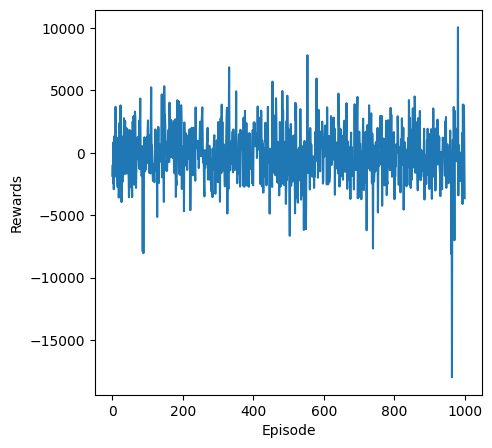

-644


In [7]:
train_v1(env, agent, max_episode_num = 1000, max_steps = 1000, save_file = "DQN_v1",
            e_greedy = 1, e_max = 1, e_min = 0.1, e_decay_rate = 0.01, show_every = 25, save_every = 100, clip_update=10)

episode, total_reward = run_fixed_episode(env, agent, max_steps = 1000, init_state = 1)
print(total_reward)
render(episode, env)

## Second try

Firstly fill a diverse buffer and train over there

In [3]:
env = env_v1()
agent = RL_Agent_v1(memory_capacity=10000)

In [5]:
fill_buffer(agent, env, int(agent.memory_capacity/2))
print( "done" )
fill_collision_buffer(agent, env, int(agent.memory_capacity/2))
print( "done" )

# train_filled(agent, 10, 64)



  0%|          | 0/5000 [00:00<?, ?it/s]

done


  0%|          | 0/5000 [00:00<?, ?it/s]

done


  0%|          | 0/10000 [00:00<?, ?it/s]

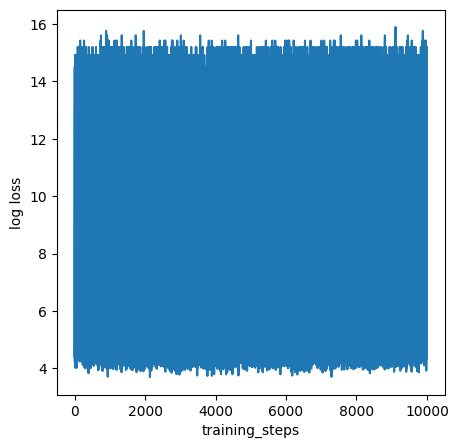

In [16]:
train_filled(agent, 10000, 64)


  0%|          | 0/1000000 [00:00<?, ?it/s]

step 4999 execution time 18.676024675369263
step 9999 execution time 39.94655966758728
step 14999 execution time 63.277376890182495
step 19999 execution time 82.47371172904968
step 24999 execution time 101.36012959480286
step 29999 execution time 120.6417088508606
step 34999 execution time 138.73956871032715
step 39999 execution time 156.8968915939331
step 44999 execution time 176.13181710243225
step 49999 execution time 193.5642488002777
step 54999 execution time 212.2698929309845
step 59999 execution time 230.06727957725525
step 64999 execution time 246.94937705993652
step 69999 execution time 264.5528426170349
step 74999 execution time 280.6416482925415
step 79999 execution time 296.6179287433624
step 84999 execution time 313.0160377025604
step 89999 execution time 329.90114665031433
step 94999 execution time 349.98018860816956
step 99999 execution time 370.7078330516815
step 104999 execution time 393.56136202812195
step 109999 execution time 415.78534483909607
step 114999 execution

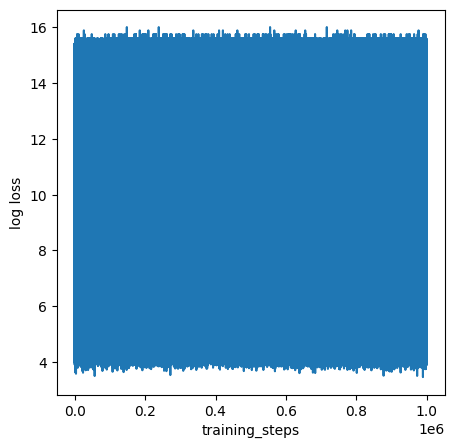

In [9]:
agent.save_memory( 'memory_buffer_2' )
agent.save_model( 'post_training_DQN_2' )
train_filled(agent, 1000000, 64)
agent.save_model( 'post_training_DQN_2' )

In [11]:
agent.save_model( 'post_training_DQN_2' )


In [19]:
agent2 = RL_Agent_v1(memory_capacity=10000, learning_rate=1e-4)
agent2.load_memory('memory_buffer_2')
agent2.load_model('post_training_DQN_2')
episode, total_reward = run_fixed_episode(env, agent)
print(total_reward)
render(episode, env)

1971


tensor([[ 0.5427,  0.0802,  0.9612, -1.0539, -0.4437, -0.3569, -0.4840,  0.4457,
          0.2719,  0.2552,  0.0047,  0.0058, -0.6686,  0.1216, -0.1001, -0.6382,
          0.2768]], grad_fn=<AddmmBackward0>)


  0%|          | 0/10000000 [00:00<?, ?it/s]

step 49999 execution time 158.04357862472534
step 99999 execution time 308.70996618270874
step 149999 execution time 463.85214018821716
step 199999 execution time 614.1132431030273
step 249999 execution time 764.9177775382996
step 299999 execution time 915.2158811092377
step 349999 execution time 1065.7549595832825
step 399999 execution time 1215.6340928077698
step 449999 execution time 1365.8256752490997
step 499999 execution time 1516.3951103687286
step 549999 execution time 1665.824301481247
step 599999 execution time 1815.108082294464
step 649999 execution time 1964.8180613517761
step 699999 execution time 2114.532889842987
step 749999 execution time 2263.9287462234497
step 799999 execution time 2413.4793977737427
step 849999 execution time 2562.758420228958
step 899999 execution time 2712.589332342148
step 949999 execution time 2861.757049560547
step 999999 execution time 3011.090740919113
step 1049999 execution time 3160.4548802375793
step 1099999 execution time 3309.788152456283

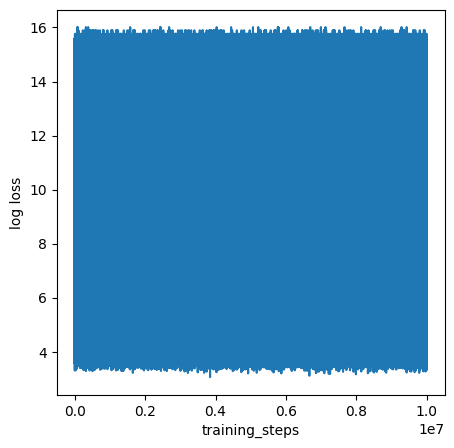

In [20]:
print( agent2.agent.forward( [2,3,0,0,2,1] ) )
train_filled(agent2, 10000000, batch_size=64, show_each=50000)
print( agent2.agent.forward( [2,3,0,0,2,1] ) )


In [21]:
agent2.save_model( 'post_training_DQN_2' )


In [22]:
episode, total_reward = run_fixed_episode(env, agent)
print(total_reward)
render(episode, env)

11


In [24]:
render_to_video(episode, env, 'trained_DQN.gif')

## Try 3

In [42]:
env = env_v3()
agent = RL_Agent_v1(memory_capacity=1000, learning_rate=1e-2, batch_size=4)

tensor([[62.7634, 62.2918, 63.3340, 62.6147, 62.7626, 63.3292, 62.4833, 62.9861,
         62.3198, 63.4687, 64.1183, 64.1804, 64.5718, 63.6451, 64.1525, 62.2549,
         62.7245]], grad_fn=<AddmmBackward0>)
episode: 249, total reward: -20, last_average_reward: 5.24, time: 14.75062370300293
episode: 499, total reward: -20, last_average_reward: 2.4, time: 30.04645037651062
episode: 749, total reward: 22, last_average_reward: 3.32, time: 44.83299970626831
episode: 999, total reward: 13, last_average_reward: 1.56, time: 60.40677833557129
episode: 1249, total reward: -20, last_average_reward: 1.18, time: 75.78891062736511
episode: 1499, total reward: 19, last_average_reward: 5.72, time: 90.51164770126343
episode: 1749, total reward: -20, last_average_reward: 6.6, time: 105.10332608222961
episode: 1999, total reward: -20, last_average_reward: 9.64, time: 119.50619959831238
episode: 2249, total reward: 19, last_average_reward: 4.82, time: 133.94670414924622
episode: 2499, total reward: 13, l

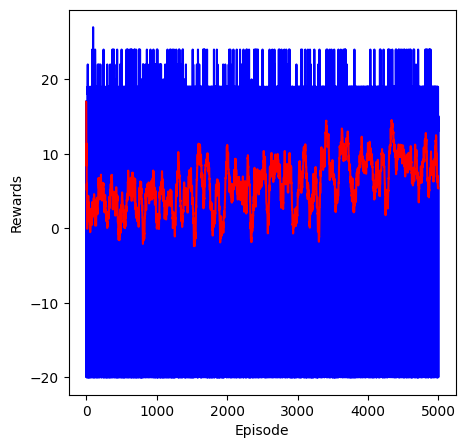

tensor([[69.5086, 69.8792, 70.8073, 71.1833, 71.3290, 70.4290, 71.0295, 70.3645,
         71.6467, 71.6415, 71.5248, 71.4391, 72.8766, 72.1532, 68.1662, 70.2710,
         70.1863]], grad_fn=<AddmmBackward0>)
-10


In [48]:
agent.save_memory('memory_buffer_4')
agent.save_model('post_training_DQN_4')

print( agent.agent.forward( [2,3,0,0,2,1] ) )
(_, mean_rewards) = train_v1(env, agent, max_episode_num = 5000, max_steps = 20, save_file = "post_training_DQN_4", mean_n=50,
            e_greedy = 1, e_max = 0.5, e_min = 0.001, e_decay_rate = 0.001, show_every = 250, save_every = 500, clip_update=10)

agent.save_model('post_training_DQN_4')
print( agent.agent.forward( [2,3,0,0,2,1] ) )
episode, total_reward = run_fixed_episode(env, agent, max_steps = 10, init_state = 1)
print(total_reward)
render(episode, env)

c:\Users\cexuz\anaconda3\envs\cuda_torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\cexuz\anaconda3\envs\cuda_torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


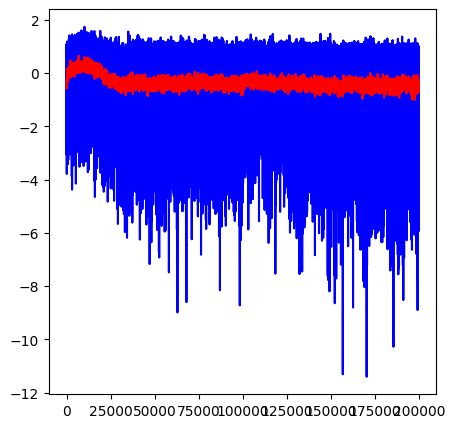

In [49]:
mean_loss = np.zeros( len(agent.loss_array))
mean_loss = [ np.mean(agent.loss_array[i-50:i+1]) for i in range(len(agent.loss_array)) ]
plt.plot( np.log(agent.loss_array),'b' )
plt.plot( np.log(mean_loss),'r' )

In [16]:
print( agent.agent.forward( [2,5.99,0,0,2,1] ) )
print( agent.agent.forward( [2,4.99,0,0,2,1] ) )
print( agent.agent.forward( [2,3.99,0,0,2,1] ) )


tensor([[0.3703, 0.4561, 0.4275, 0.4233, 0.3219, 0.2791, 0.3870, 0.6994, 0.6849,
         0.4999, 0.6282, 0.5002, 0.4403, 0.5387, 0.4350, 0.2256, 0.2856]],
       grad_fn=<AddmmBackward0>)
tensor([[0.3975, 0.4839, 0.4508, 0.4504, 0.3463, 0.3077, 0.4114, 0.7339, 0.7104,
         0.5318, 0.6466, 0.5235, 0.4717, 0.5648, 0.4567, 0.2526, 0.3113]],
       grad_fn=<AddmmBackward0>)
tensor([[0.4202, 0.5071, 0.4702, 0.4730, 0.3667, 0.3316, 0.4318, 0.7627, 0.7316,
         0.5585, 0.6620, 0.5429, 0.4978, 0.5865, 0.4749, 0.2751, 0.3327]],
       grad_fn=<AddmmBackward0>)


In [9]:
import torch
import torch.nn.functional as F
env = env_v2()
agent = RL_Agent_v1(memory_capacity=10000, learning_rate=1e-2)
agent.load_memory('memory_buffer_4')
agent.load_model('post_training_DQN_4')


In [44]:
import torch
import torch.nn.functional as F

input = torch.tensor( [2,3.99,0,0,2,1], dtype=torch.float32, device=torch.device("cpu") )
x = agent.agent.linear1(input)
x2 = agent.clipped.linear1(input)
print( x )
print( x-x2 )
x = F.relu(x)
x2 = F.relu(x2)
print( x )
print( x-x2 )
x = agent.agent.linear2(x)
x2 = agent.clipped.linear2(x2)
print( x )
print( x-x2 )
x = F.relu(x)
x2 = F.relu(x2)
print( x )
print( x-x2 )
x = agent.agent.linear3(x)
x2 = agent.clipped.linear3(x2)
print( x )
print( x2 )

tensor([ 1.0584e+00, -6.6019e-02, -9.0023e-01,  3.3464e-01,  1.3797e-01,
        -1.1845e+00, -1.0098e+00, -1.1784e+00, -1.7022e+00, -9.1732e-01,
         1.7939e-01, -1.8112e+00,  6.8601e-01, -1.5785e+00,  1.0024e+00,
        -5.8004e-01, -1.3872e+00, -1.2756e+00, -4.6574e-01,  1.2861e+00,
         6.4430e-01, -2.0329e-01,  1.1537e+00, -4.0497e-01,  1.0898e+00,
         2.0346e+00, -6.5227e-01,  2.1392e+00,  1.5357e+00,  1.7315e+00,
        -1.3385e+00, -1.5752e+00, -1.3794e+00,  1.6391e-02,  6.8692e-01,
        -3.6797e-01,  5.4407e-01, -1.1949e+00,  1.0066e+00,  2.3250e-01,
        -1.0869e+00,  8.6828e-02, -1.2221e+00, -1.7715e+00,  1.5525e-01,
        -4.5269e-01,  9.1010e-01,  7.4699e-01,  2.3257e+00, -1.0960e+00,
         1.2399e+00,  1.2652e+00, -2.1321e-01, -8.5428e-02, -1.9170e+00,
        -4.8568e-01,  8.1186e-01,  1.5656e+00,  1.3301e+00,  7.5696e-01,
        -1.7071e+00,  2.6727e-01, -1.7962e+00,  7.7912e-01, -7.6305e-01,
         1.0826e-01, -1.6802e+00, -2.2056e+00,  4.8

## Try 4 with agent v2, fixed target reward

In [55]:
from collections import namedtuple
import torch

Transition = namedtuple('Transition',
                        ('state', 'action', 'done', 'next_state', 'reward'))

class RL_Agent_v2(RL_Agent_v1):
    def __init__(self, n_actions = 17, input_size = 6, learning_rate=1e-3, batch_size = 128, tau = 1e-2,
                gamma = 1-1e-2, nlayer1 = 256, nlayer2 = 256, memory_capacity = 10000, dtype = torch.float32 ):
        super(RL_Agent_v2, self).__init__(n_actions, input_size, learning_rate, batch_size, tau,
                gamma, nlayer1, nlayer2, memory_capacity, dtype )
        self.device = torch.device("cpu")
    
    def learn(self, batch_size = None):
        if ( batch_size == None ):
            batch_size = self.batch_size
        transitions = self.memory.sample(batch_size)
        batch = Transition(*zip(*transitions))      # array of transitions -> transition of arrays
        states_batch = torch.tensor( np.array(batch.state), dtype=self.dtype, device=self.device, requires_grad=False )
        state_action_values = self.agent.forward( states_batch ).gather(1, torch.tensor( [batch.action], device=self.device, requires_grad=False) )

        expected_state_action_values = torch.tensor( batch.reward )
        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(0))
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.agent.parameters():       # clip the range of the gradients
            param.grad.data.clamp_(-100, 100)
        self.optimizer.step()
        self.loss_array.append( loss.data )
        return loss.data



tensor([[-0.1431,  0.0347,  0.0921, -0.1425,  0.0378,  0.1089,  0.0185, -0.3277,
         -0.1347,  0.3391, -0.0421, -0.5945, -0.1294,  0.2500, -0.1554, -0.0294,
         -0.2708]], grad_fn=<AddmmBackward0>)
episode: 249, total reward: 24, last_average_reward: 11.92, time: 11.218160152435303
episode: 499, total reward: 17, last_average_reward: 12.74, time: 23.002906799316406
episode: 749, total reward: 19, last_average_reward: 14.94, time: 35.0171434879303
episode: 999, total reward: 19, last_average_reward: 13.42, time: 47.64921593666077
episode: 1249, total reward: 19, last_average_reward: 14.16, time: 59.812243938446045
episode: 1499, total reward: 19, last_average_reward: 16.22, time: 73.17136025428772
episode: 1749, total reward: 19, last_average_reward: 14.22, time: 86.02705979347229
episode: 1999, total reward: 19, last_average_reward: 16.3, time: 99.27545285224915
episode: 2249, total reward: 19, last_average_reward: 15.82, time: 112.42052936553955
episode: 2499, total reward: 

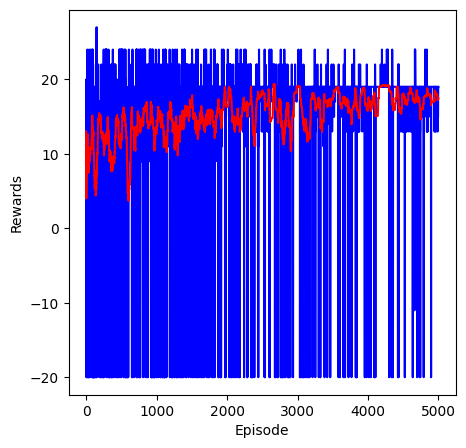

tensor([[-0.6894, -0.7009, -0.4148,  0.7116, -0.9992,  0.7477, -0.8664, -0.8953,
          0.9480,  0.8277,  0.6278,  0.9017, -0.0237, -0.3045, -0.9210, -0.7583,
         -0.5808]], grad_fn=<AddmmBackward0>)
9


In [56]:
env = env_v3()
agent = RL_Agent_v2(memory_capacity=1000, learning_rate=1e-2, batch_size=4)

agent.save_memory('memory_buffer_4')
agent.save_model('post_training_DQN_4')

print( agent.agent.forward( [2,3,0,0,2,1] ) )
(_, mean_rewards) = train_v1(env, agent, max_episode_num = 5000, max_steps = 20, save_file = "post_training_DQN_4", mean_n=50,
            e_greedy = 1, e_max = 0.5, e_min = 0.001, e_decay_rate = 0.001, show_every = 250, save_every = 500, clip_update=10)

agent.save_model('post_training_DQN_4')
print( agent.agent.forward( [2,3,0,0,2,1] ) )
episode, total_reward = run_fixed_episode(env, agent, max_steps = 10, init_state = 1)
print(total_reward)
render(episode, env)

c:\Users\cexuz\anaconda3\envs\cuda_torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\cexuz\anaconda3\envs\cuda_torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


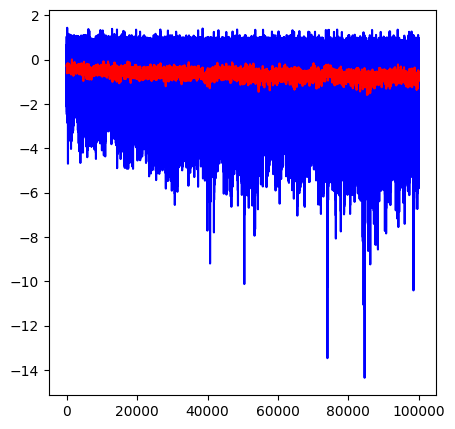

In [57]:
mean_loss = np.zeros( len(agent.loss_array))
mean_loss = [ np.mean(agent.loss_array[i-50:i+1]) for i in range(len(agent.loss_array)) ]
plt.plot( np.log(agent.loss_array),'b' )
plt.plot( np.log(mean_loss),'r' )

In [12]:
print( agent.agent.forward( [2,5.99,0,0,2,1] ) )
print( agent.agent.forward( [2,4.99,0,0,2,1] ) )
print( agent.agent.forward( [2,3.99,0,0,2,1] ) )


tensor([[1.3863, 1.6461, 1.4451]], grad_fn=<AddmmBackward0>)
tensor([[1.3863, 1.6461, 1.4451]], grad_fn=<AddmmBackward0>)
tensor([[1.3863, 1.6461, 1.4451]], grad_fn=<AddmmBackward0>)


In [51]:
for param in agent.agent.parameters():       
    print(param.data)

print('adsfaf')
for param in agent.clipped.parameters():       
    print(param.data)

tensor([[ 0.0252, -0.1756, -0.4619, -0.5997,  0.1363, -0.5401],
        [-0.3988,  0.0283,  0.0801,  0.0698, -0.1595,  0.2860],
        [-0.3627, -0.1312, -0.1084, -0.2919,  0.0126,  0.0303],
        ...,
        [-0.5731, -0.0128,  0.0785, -0.2520, -0.5308, -0.3911],
        [ 0.2760, -0.2572,  0.0579,  0.1587, -0.2449,  0.1178],
        [-0.6343, -0.0546,  0.2162, -0.4932, -0.1238, -0.5774]])
tensor([-6.1449e-01, -4.8155e-01,  2.9292e-01, -3.7273e-01, -5.6157e-01,
        -1.0368e-01,  3.0760e-01,  3.1904e-01,  1.2250e-01,  1.2713e-01,
        -1.0265e-01, -3.5132e-01, -2.1277e-01, -3.4014e-01, -1.1404e-02,
        -4.5129e-01, -5.4890e-02, -3.8980e-01,  2.3168e-01, -4.5593e-01,
        -1.8369e-01,  1.5692e-01,  6.0444e-02, -3.4867e-01, -3.5100e-01,
        -1.6500e-01, -3.1308e-01, -6.0307e-01, -3.1636e-01, -1.3752e-01,
         7.6499e-02,  2.4713e-01, -1.4429e-01, -9.9850e-02,  1.3683e-01,
        -4.3055e-01,  2.2214e-01,  2.2157e-01, -1.1096e-01,  9.8052e-02,
        -4.4343e-0

In [52]:
self = agent
# agent.load_model('post_training_DQN_3')
batch_size = 8
for i in range(1):
    transitions = self.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))      # array of transitions -> transition of arrays
    states_batch = torch.tensor( np.array(batch.state), dtype=self.dtype, device=self.device, requires_grad=False )
    done_mask = torch.tensor(batch.done, requires_grad=False)

    state_action_values = self.agent.forward( states_batch ).gather(1, torch.tensor( [batch.action], device=self.device, requires_grad=False) )
    not_done_next_state = torch.tensor(  np.array([ batch.next_state[i] for i in range(batch_size) if not done_mask[i] ]), dtype=torch.float32, device=self.device, requires_grad=False )

    with torch.no_grad():
        next_state_values = torch.zeros( batch_size, device = self.device, requires_grad=False, dtype=self.dtype )
        next_state_values[ torch.logical_not( done_mask ) ] = self.clipped.forward( not_done_next_state ).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma) + torch.tensor(batch.reward, device=self.device, requires_grad=False, dtype=self.dtype)

    loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(0))
    self.optimizer.zero_grad()
    loss.backward()
    for param in self.agent.parameters():       # clip the range of the gradients
        param.grad.data.clamp_(-100, 100)
    # self.optimizer.step()
    print(loss)

tensor(0.6562, grad_fn=<SmoothL1LossBackward0>)


In [53]:
np.set_printoptions(precision = 4)
print(states_batch)
print( np.array(batch.action) )
print(np.array(batch.next_state) )
print(batch.reward)
print( next_state_values )
print(state_action_values)
print(expected_state_action_values)

tensor([[ 2.0056,  3.0124,  0.4048,  0.8952,  1.8907,  2.7788],
        [ 2.0865,  3.1913,  0.4040,  0.8934,  1.8710,  2.8500],
        [ 1.4191,  3.0252, -0.4536, -0.2817,  2.0511,  2.8500],
        [ 1.5434,  3.9455, -0.4089,  0.8467,  2.1337,  2.8500],
        [ 2.4778,  3.8359,  0.5404,  0.7498,  1.8710,  2.8500],
        [ 2.0000,  3.0000,  0.0000,  0.0000,  1.6663,  2.8500],
        [ 2.4778,  3.8359,  0.5404,  0.7498,  1.8710,  2.8500],
        [ 2.0000,  3.0000,  0.0000,  0.0000,  1.7617,  2.7213]])
[11 11  8  8  9 13 11 13]
[[ 2.0461  3.1019  0.4044  0.8943  1.871   2.85  ]
 [ 2.1269  3.2807  0.4036  0.8925  1.871   2.85  ]
 [ 1.3738  2.997  -0.4528 -0.2812  2.0511  2.85  ]
 [ 1.5025  4.0302 -0.4084  0.8458  2.1337  2.85  ]
 [ 2.5318  3.9109  0.5398  0.749   1.871   2.85  ]
 [ 2.      3.      0.      0.      1.6663  2.85  ]
 [ 2.5318  3.9109  0.5398  0.749   1.871   2.85  ]
 [ 2.      3.      0.      0.      1.7022  2.8016]]
(1, 1, -1, 1, 1, -1, 1, -1)
tensor([72.1465, 72.1465

In [33]:
for param in self.agent.parameters():       # clip the range of the gradients
    print(param.data)

NameError: name 'torch' is not defined

In [35]:
import torch
with torch.no_grad():
    for param in agent.agent.parameters():       # clip the range of the gradients
        param.copy_( param.data * 0.01)

## Try 5, defensive mode

tensor([[-1.2256e-05,  1.1630e-05, -2.0674e-06]], grad_fn=<AddmmBackward0>)
episode: 249, total reward: -236, last_average_reward: -116.64, time: 30.694628477096558
episode: 499, total reward: 45, last_average_reward: -139.2, time: 59.57273483276367
episode: 749, total reward: -183, last_average_reward: -153.7, time: 84.95616126060486
episode: 999, total reward: -344, last_average_reward: -153.14, time: 109.6704797744751


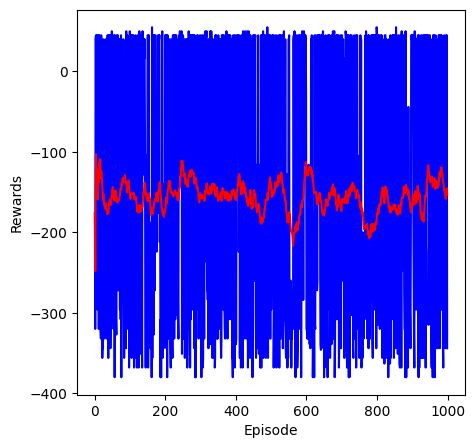

tensor([[0.0736, 0.3647, 0.4688]], grad_fn=<AddmmBackward0>)
episode: 249, total reward: 45, last_average_reward: -118.14, time: 26.149251222610474
episode: 499, total reward: -368, last_average_reward: -153.66, time: 51.61772012710571
episode: 749, total reward: 45, last_average_reward: -178.22, time: 77.67384147644043
episode: 999, total reward: -176, last_average_reward: -136.84, time: 103.86216235160828


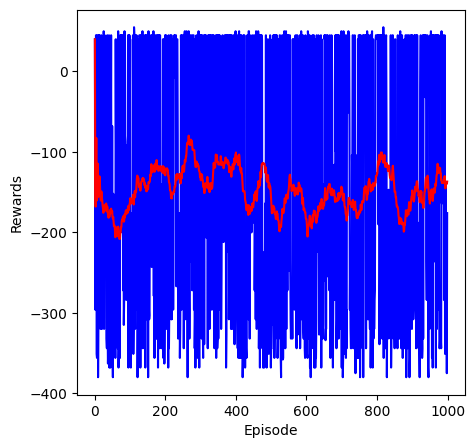

tensor([[1.3863, 1.6461, 1.4451]], grad_fn=<AddmmBackward0>)


In [10]:
from env_versions import env_v4

env = env_v4()
agent = RL_Agent_v1(memory_capacity=1000, learning_rate=3e-2, batch_size=4, n_actions = 3, nlayer1=64, nlayer2=64, gamma=0.7)
with torch.no_grad():
    for param in agent.agent.parameters():       # clip the range of the gradients
        param.copy_( param.data * 0.01)
print( agent.agent.forward( [2,3,0,0,2,1] ) )

agent.learn_mode = 'reward'
(all_rewards, mean_rewards) = train_v1(env, agent, max_episode_num = 1000, max_steps = 40, save_file = "post_training_DQN_5", mean_n=50,
            e_greedy = 1, e_max = 1, e_min = 0.01, e_decay_rate = 0.001, show_every = 250, save_every = 500)
print( agent.agent.forward( [2,3,0,0,2,1] ) )

agent.save_memory('memory_buffer_5')
agent.save_model('post_training_DQN_5')


c:\Users\cexuz\anaconda3\envs\cuda_torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\cexuz\anaconda3\envs\cuda_torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


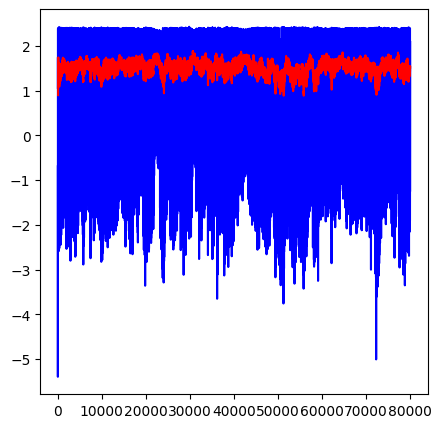

In [11]:
mean_loss = np.zeros( len(agent.loss_array))
mean_loss = [ np.mean(agent.loss_array[i-50:i+1]) for i in range(len(agent.loss_array)) ]
plt.plot( np.log(agent.loss_array),'b' )
plt.plot( np.log(mean_loss),'r' )

In [28]:
episode, total_reward, actions = run_fixed_episode_v5(env, agent, max_steps = 20, init_state = 1)
print(total_reward)
print(actions)
render(episode, env)

-76
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [29]:
print( agent.agent.forward( [2,5.99,0,0,2,1] ) )
print( agent.agent.forward( [2,4.99,0,0,2,1] ) )
print( agent.agent.forward( [2,3.99,0,0,2,1] ) )


tensor([[-0.2337,  0.6608, -4.7693]], grad_fn=<AddmmBackward0>)
tensor([[-0.2337,  0.6608, -4.7693]], grad_fn=<AddmmBackward0>)
tensor([[-0.2337,  0.6608, -4.7693]], grad_fn=<AddmmBackward0>)


## Try 6, defensive mode, pretrain clipp function

In [41]:
def compute_colision(v_ball, p_ball, p_hand):
    v_perp = np.array([1,0])
    Lamb = np.dot(v_ball,v_perp)
    pc = p_ball + v_ball*Lamb.reshape( v_ball.shape[0], 1 )
    return pc

def clip_function(curr_states, rewards, next_states, actions):
    curr_states = np.array(curr_states)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    actions = np.array( actions )
    batch_size = rewards.shape[0]
    expected_value = np.zeros( batch_size )
    p_hand = curr_states[:,4:6]
    pc = compute_colision( curr_states[:,2:4], curr_states[:,0:2], p_hand )
    good_ac = np.logical_or( np.logical_and( pc[:,0] < p_hand[:,0], actions == 1), np.logical_and(pc[:,0] > p_hand[:,0], actions == 0) )
    bad_act = np.logical_or( np.logical_and( pc[:,0] < p_hand[:,0], actions == 0), np.logical_and(pc[:,0] > p_hand[:,0], actions == 1) )
    expected_value[  np.where(good_ac)[0]  ] = 50
    expected_value[  np.where(bad_act)[0]  ] = -50
    return expected_value
  

tensor([[-0.0001,  0.0001, -0.0012]], grad_fn=<AddmmBackward0>)
episode: 249, total reward: -320, last_average_reward: -143.62, time: 24.625938415527344
episode: 499, total reward: 40, last_average_reward: -133.96, time: 48.86110544204712
episode: 749, total reward: 50, last_average_reward: -170.74, time: 72.91601848602295
episode: 999, total reward: 45, last_average_reward: -122.8, time: 97.02464175224304


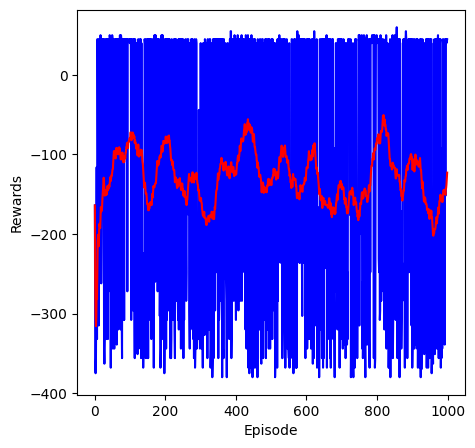

tensor([[ 3.0355e+01,  3.7986e+01, -4.9605e-03]], grad_fn=<AddmmBackward0>)


In [46]:
env = env_v4()
agent = RL_Agent_v1(memory_capacity=1000, learning_rate=1e-3, batch_size=4, n_actions = 3, nlayer1=64, nlayer2=64, gamma=0.99)
print( agent.agent.forward( [2,3,0,0,2,1] ) )
agent.function = clip_function
agent.learn_mode = 'function'
(all_rewards, mean_rewards) = train_v1(env, agent, max_episode_num = 1000, max_steps = 40, save_file = "post_training_DQN_5", mean_n=50,
            e_greedy = 1, e_max = 1, e_min = 0.01, e_decay_rate = 0.001, show_every = 250, save_every = 500)
print( agent.agent.forward( [2,3,0,0,2,1] ) )



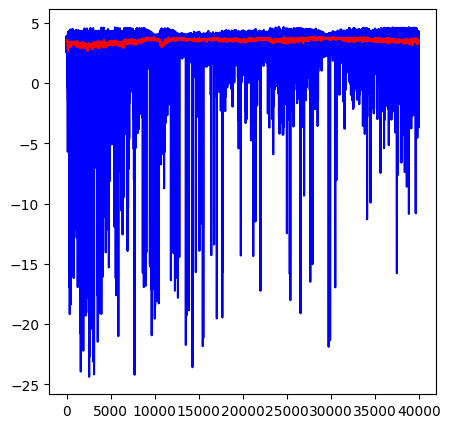

In [47]:
mean_loss = np.zeros( len(agent.loss_array))
mean_loss = [ np.mean(agent.loss_array[i-50:i+1]) for i in range(len(agent.loss_array)) ]
plt.plot( np.log(agent.loss_array),'b' )
plt.plot( np.log(mean_loss),'r' )

In [55]:
print( agent.agent.forward( [1,5.99,-1,0,2,1] ) )
print( agent.agent.forward( [2,4.99,-1,0,2,1] ) )
print( agent.agent.forward( [3,3.99,-1,0,2,1] ) )


tensor([[29.5756, 39.1755, -0.0468]], grad_fn=<AddmmBackward0>)
tensor([[29.7625, 35.7078, -0.0514]], grad_fn=<AddmmBackward0>)
tensor([[29.8711, 31.0383, -0.0593]], grad_fn=<AddmmBackward0>)


In [49]:
episode, total_reward, actions = run_fixed_episode_v5(env, agent, max_steps = 20, init_state = 1)
print(total_reward)
print(actions)
render(episode, env)

-126
[0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]


episode: 249, total reward: -308, last_average_reward: -138.58, time: 23.947222232818604
episode: 499, total reward: -363, last_average_reward: -153.78, time: 47.70212006568909
episode: 749, total reward: -68, last_average_reward: -98.66, time: 71.7447669506073
episode: 999, total reward: 40, last_average_reward: -101.88, time: 95.98607897758484
episode: 1249, total reward: -368, last_average_reward: -137.46, time: 120.46236515045166
episode: 1499, total reward: 45, last_average_reward: -134.92, time: 144.94694709777832
episode: 1749, total reward: -284, last_average_reward: -125.46, time: 169.7753403186798
episode: 1999, total reward: 45, last_average_reward: -141.06, time: 194.16577410697937
episode: 2249, total reward: -351, last_average_reward: -149.4, time: 217.73925065994263
episode: 2499, total reward: -291, last_average_reward: -151.32, time: 241.2210988998413
episode: 2749, total reward: 45, last_average_reward: -176.9, time: 264.8301434516907
episode: 2999, total reward: 50, 

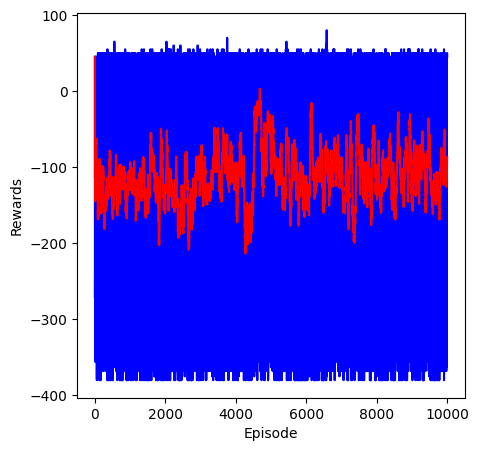

c:\Users\cexuz\anaconda3\envs\cuda_torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\cexuz\anaconda3\envs\cuda_torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


25
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]


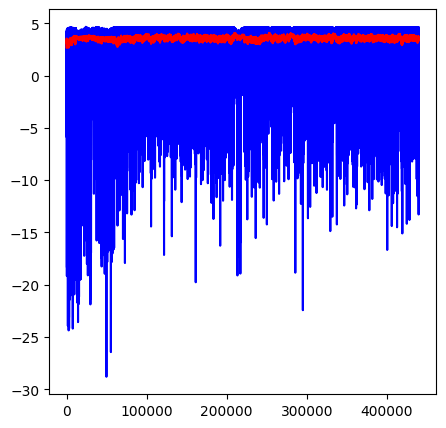

In [52]:
import torch
agent.function = clip_function
agent.learn_mode = 'function'
agent.optimizer = torch.optim.Adam(agent.agent.parameters(), lr=5e-4)

(all_rewards, mean_rewards) = train_v1(env, agent, max_episode_num = 10000, max_steps = 40, save_file = "post_training_DQN_5", mean_n=50,
            e_greedy = 1, e_max = 1, e_min = 0.01, e_decay_rate = 0.001, show_every = 250, save_every = 500)

mean_loss = np.zeros( len(agent.loss_array))
mean_loss = [ np.mean(agent.loss_array[i-50:i+1]) for i in range(len(agent.loss_array)) ]
plt.plot( np.log(agent.loss_array),'b' )
plt.plot( np.log(mean_loss),'r' )

episode, total_reward, actions = run_fixed_episode_v5(env, agent, max_steps = 20, init_state = 1)
print(total_reward)
print(actions)
render(episode, env)

episode: 249, total reward: -179, last_average_reward: -54.78, time: 16.406595706939697
episode: 499, total reward: -155, last_average_reward: -59.26, time: 32.88170599937439
episode: 749, total reward: 30, last_average_reward: -59.36, time: 49.09015107154846
episode: 999, total reward: -167, last_average_reward: -61.38, time: 65.41380310058594
episode: 1249, total reward: -54, last_average_reward: -58.5, time: 82.01714277267456
episode: 1499, total reward: -167, last_average_reward: -74.64, time: 98.55388379096985
episode: 1749, total reward: -143, last_average_reward: -79.24, time: 115.31608128547668
episode: 1999, total reward: 30, last_average_reward: -68.86, time: 131.9010570049286
episode: 2249, total reward: 25, last_average_reward: -64.08, time: 148.3284523487091
episode: 2499, total reward: 30, last_average_reward: -42.22, time: 165.42101454734802
episode: 2749, total reward: 25, last_average_reward: -56.66, time: 182.46275353431702
episode: 2999, total reward: -203, last_aver

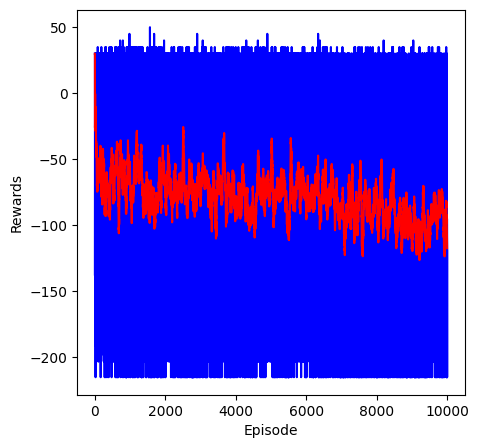

c:\Users\cexuz\anaconda3\envs\cuda_torch\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\cexuz\anaconda3\envs\cuda_torch\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-160
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([[-50.0860, -18.2357, -47.7647]], grad_fn=<AddmmBackward0>)
tensor([[-47.0814, -16.0278, -44.5565]], grad_fn=<AddmmBackward0>)
tensor([[-44.8128, -15.6719, -42.2102]], grad_fn=<AddmmBackward0>)


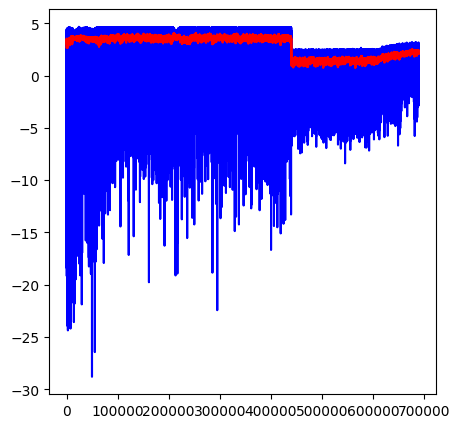

In [56]:
agent.function = clip_function
agent.learn_mode = 'clipped'
agent.optimizer = torch.optim.Adam(agent.agent.parameters(), lr=5e-4)

(all_rewards, mean_rewards) = train_v1(env, agent, max_episode_num = 10000, max_steps = 25, save_file = "post_training_DQN_6", mean_n=50,
            e_greedy = 0.5, e_max = 0.5, e_min = 0.01, e_decay_rate = 0.001, show_every = 250, save_every = 500)

mean_loss = np.zeros( len(agent.loss_array))
mean_loss = [ np.mean(agent.loss_array[i-50:i+1]) for i in range(len(agent.loss_array)) ]
plt.plot( np.log(agent.loss_array),'b' )
plt.plot( np.log(mean_loss),'r' )

episode, total_reward, actions = run_fixed_episode_v5(env, agent, max_steps = 20, init_state = 1)
print(total_reward)
print(actions)
render(episode, env)

print( agent.agent.forward( [1,5.99,-1,0,2,1] ) )
print( agent.agent.forward( [2,4.99,-1,0,2,1] ) )
print( agent.agent.forward( [3,3.99,-1,0,2,1] ) )


In [59]:
agent.load_model('post_training_DQN_5')
episode, total_reward, actions = run_fixed_episode_v5(env, agent, max_steps = 30, init_state = 1)
print(total_reward)
print(actions)
render(episode, env)


35
[0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]


## Try 7, general game custom reward with gamma flexiblility

In [ ]:
def train_v2(env, agent, max_episode_num = 5000, max_steps = 99, save_file = "RL_agent", mean_n = 10,
             e_greedy = -1, e_max = 1, e_min = 0.5, e_decay_rate = 0.01, clip_update = 10, show_every = 10, save_every = 10):
    start_time = time.time()
    all_rewards = []
    mean_rewards = []
    # optimizer = optim.RMSprop(agent.parameters())
    for episode in range(max_episode_num):
        env.reset()
        rewards = []
        state = np.concatenate( (env.air_hockey.ball_pos, env.air_hockey.ball_vel, env.air_hockey.self_hand_pos)  )
        if(e_greedy != -1):
            e_greedy = e_min + (e_max - e_min)*np.exp(-e_decay_rate*episode)

        for steps in range(max_steps):
            action = agent.get_action(state, e_greedy)
            new_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            agent.step( state, action, done, new_state, reward )
            if done:
                break
            state = new_state
        all_rewards.append(np.sum(rewards))
        mean_rewards.append( np.mean(all_rewards[-mean_n:]) )
        if (episode+1) % show_every == 0:
            sys.stdout.write("episode: {}, total reward: {}, last_average_reward: {}, time: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  
                    np.round(np.mean(all_rewards[-mean_n:]), decimals = 3), time.time()-start_time))
            
        if ( episode+1 ) % save_every == 0:        # update the clipped
            agent.save_model(save_file)


    plt.figure()
    plt.subplot(111)
    plt.plot(all_rewards,'b')
    plt.plot(mean_rewards,'r')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.show()
    return (all_rewards, mean_rewards)

def compute_colision(v_ball, p_ball, p_hand):
    v_perp = np.array([1,0])
    Lamb = np.dot(v_ball,v_perp)
    pc = p_ball + v_ball*Lamb.reshape( v_ball.shape[0], 1 )
    return pc

def custom_reward(curr_states, rewards, next_states, actions):
    curr_states = np.array(curr_states)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    actions = np.array( actions )
    batch_size = rewards.shape[0]
    expected_value = np.zeros( batch_size )
    p_hand = curr_states[:,4:6]
    pc = compute_colision( curr_states[:,2:4], curr_states[:,0:2], p_hand )
    good_ac = np.logical_or( np.logical_and( pc[:,0] < p_hand[:,0], actions == 1), np.logical_and(pc[:,0] > p_hand[:,0], actions == 0) )
    bad_act = np.logical_or( np.logical_and( pc[:,0] < p_hand[:,0], actions == 0), np.logical_and(pc[:,0] > p_hand[:,0], actions == 1) )
    expected_value[  np.where(good_ac)[0]  ] = 50
    expected_value[  np.where(bad_act)[0]  ] = -50
    return expected_value
  